# Applying Matched Filter to Detect Human Faces

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.patches as patches
from scipy.signal import convolve2d

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset

In [ ]:

faces = pd.read_csv('/content/drive/MyDrive/CS216 Files/HW2/Face Data/faces.csv')

# Randomly sample 500 images
faces = faces.sample(n=500, random_state=42)

# Directory for images
image_dir = '/content/drive/MyDrive/CS216 Files/HW2/Face Data/images'

# Visualize data

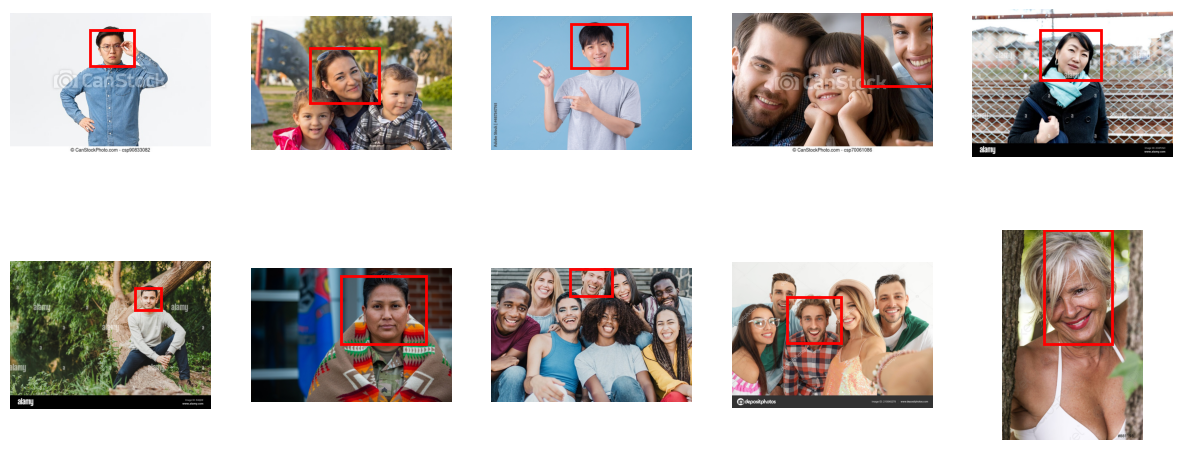

In [ ]:

sample_images = faces.sample(n=10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    image_path = os.path.join(image_dir, row['image_name'])
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')

    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
    bbox = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(bbox)

plt.show()

# Extract face templates

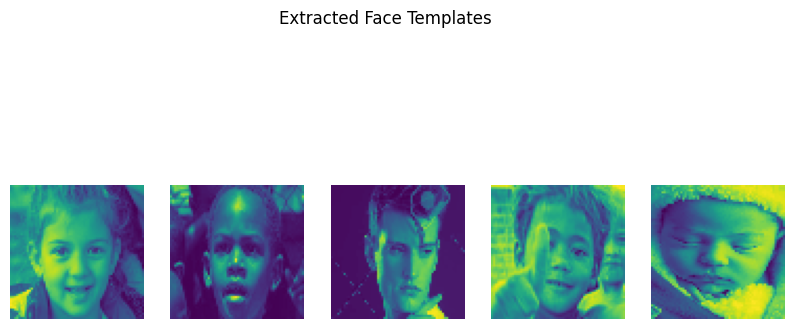

In [ ]:

def extract_face_templates(data, img_dir):
    templates = []
    for _, row in data.iterrows():
        img_path = os.path.join(img_dir, row['image_name'])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            face = img[int(row['y0']):int(row['y1']), int(row['x0']):int(row['x1'])]
            face_resized = cv2.resize(face, (64, 64))  # Resize to fixed size
            templates.append(cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY))  # Convert to grayscale for filtering
    return templates

# Extract templates
face_templates = extract_face_templates(faces, image_dir)

# Plot a few templates to verify correctness
def plot_templates(templates, num=5):
    plt.figure(figsize=(10, 5))
    for i in range(min(num, len(templates))):
        plt.subplot(1, num, i + 1)
        plt.imshow(templates[i])
        plt.axis('off')
    plt.suptitle('Extracted Face Templates')
    plt.show()

# Plot first few templates
plot_templates(face_templates)

# Matched Filter Method

In [ ]:
# Create the matched filter
def create_matched_filter(templates):
    avg_template = np.mean(templates, axis=0)
    normalized_template = (avg_template - np.mean(avg_template)) / np.std(avg_template)
    return normalized_template

matched_filter = create_matched_filter(face_templates)

# Apply the matched filter on test images
def apply_matched_filter(img, filter_kernel, threshold=0.5):
    normalized_img = (img - np.mean(img)) / np.std(img)
    response = convolve2d(normalized_img, filter_kernel, mode='same')
    detection = response > threshold * np.max(response)
    return detection, response

# Non-Maximum Suppression with IoU

In [ ]:

def non_max_suppression(detections, response, threshold=0.2, iou_threshold=0.2):
    boxes = [(x, y, response[y, x]) for y in range(detections.shape[0]) for x in range(detections.shape[1]) if detections[y, x]]
    boxes = sorted(boxes, key=lambda b: b[2], reverse=True)  # Sort by confidence
    selected_boxes = []

    def iou(box1, box2, size=64):
        x1, y1 = box1[:2]
        x2, y2 = box2[:2]
        xi1, yi1 = max(x1, x2), max(y1, y2)
        xi2, yi2 = min(x1 + size, x2 + size), min(y1 + size, y2 + size)
        inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
        union_area = 2 * (size * size) - inter_area
        return inter_area / union_area

    while boxes:
        best_box = boxes.pop(0)
        selected_boxes.append(best_box)
        boxes = [box for box in boxes if iou(best_box, box) < iou_threshold]

    return selected_boxes

# Test on new dataset

Testing the matched filter on test images:


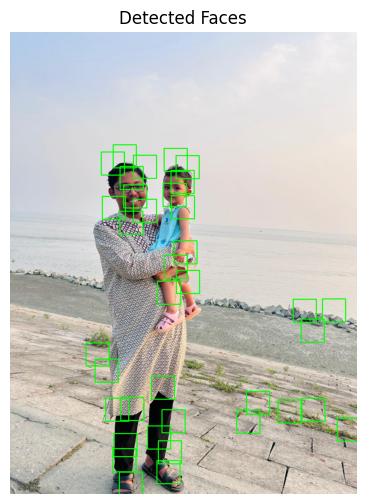

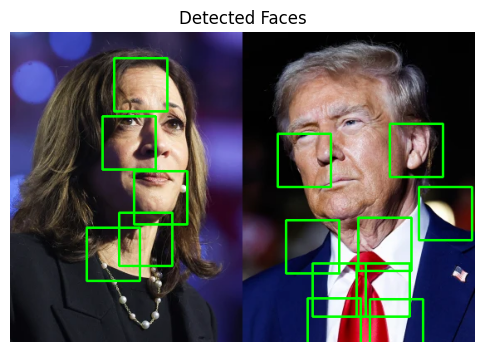

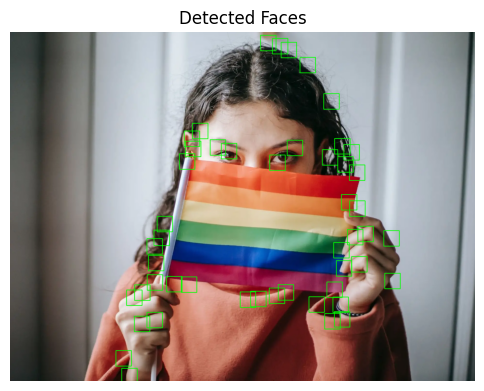

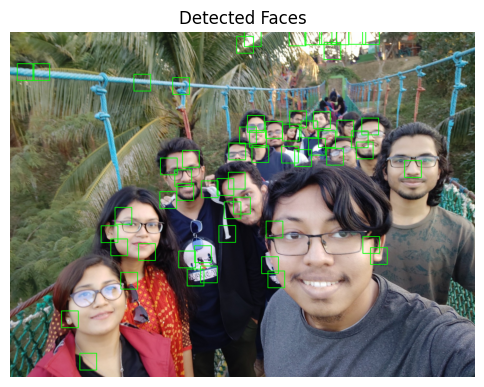

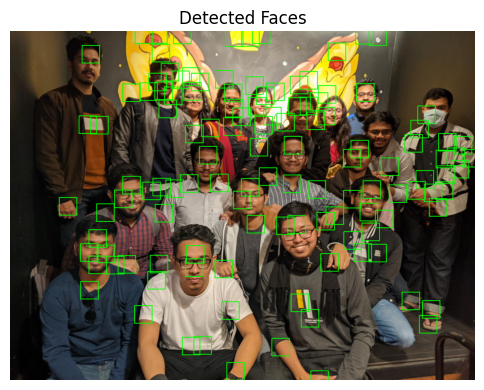

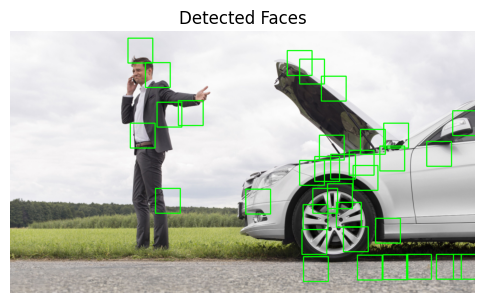

In [ ]:

def test_matched_filter(test_dir, filter_kernel, threshold=0.5):
    test_images = [f for f in os.listdir(test_dir)]
    for image_name in test_images:
        img_path = os.path.join(test_dir, image_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        detections, response = apply_matched_filter(gray, filter_kernel, threshold)

        nms_detections = non_max_suppression(detections, response, 0.2)

        for x, y, _ in nms_detections:
            cv2.rectangle(img, (x - 32, y - 32), (x + 32, y + 32), (0, 255, 0), 2)

        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Detected Faces")
        plt.axis('off')
        plt.show()

# Test directory
test_dir = "/content/drive/MyDrive/CS216 Files/HW2/Test Images"

# Test the matched filter
print("Testing the matched filter on test images:")
test_matched_filter(test_dir, matched_filter)

As we can see, similar to linear classifier, it doesn't perform well on face detection as well.